Introductory Video:
https://www.youtube.com/watch?v=hUnRCxnydCc

In [ ]:
!pip install lime

    100% |████████████████████████████████| 276kB 416kB/s ta 0:00:01
    100% |████████████████████████████████| 28.9MB 494kB/s ta 0:00:01   25% |████████▎                       | 7.4MB 559kB/s eta 0:00:39
    100% |████████████████████████████████| 706kB 621kB/s ta 0:00:01
    67% |█████████████████████▋          | 3.3MB 639kB/s eta 0:00:03

In [1]:
import lime
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

For this tutorial, we'll be using the 20 newsgroups dataset. In particular, for simplicity, we'll use a 2-class subset: atheism and christianity.

In [2]:
categories = ['alt.atheism', 'soc.religion.christian']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)
class_names = ['atheism', 'christian']
# We define the class_names so we can use it later

Let's see what the data looks like

In [3]:
newsgroups_train.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [4]:
newsgroups_train['data'][4]

'From: mayne@ds3.scri.fsu.edu (Bill Mayne)\nSubject: Re: Ancient Books\nOrganization: Supercomputer Computations Research Institute\nLines: 25\n\nIn article <Apr.13.00.09.02.1993.28445@athos.rutgers.edu> miner@kuhub.cc.ukans.edu writes:\n>[Any former atheists converted by argument?}\n>This is an excellent question and I\'ll be anxious to see if there are\n>any such cases.  I doubt it.  In the medieval period (esp. 10th-cent.\n>when Aquinas flourished) argument was a useful tool because everyone\n>"knew the rules."  Today, when you can\'t count on people knowing even\n>the basics of logic or seeing through rhetoric, a good argument is\n>often indistinguishable from a poor one.\n\nThe last sentence is ironic, since so many readers of\nsoc.religion.christian seem to not be embarrassed by apologists such as\nJosh McDowell and C.S. Lewis. The above also expresses a rather odd sense\nof history. What makes you think the masses in Aquinas\' day, who were\nmostly illiterate, knew any more abou

In [5]:
newsgroups_train['target'][4]

1

# Vectorize with TFIDF
To make text readable by the computer, we are going to use the TFIDF Vectorizer
This is known as Term Frequency inverse Document Frequency

Let’s take an example to get a clearer understanding.

Sentence 1 : The car is driven on the road.

Sentence 2: The truck is driven on the highway.

In this example, each sentence is a separate document.

https://medium.freecodecamp.org/how-to-process-textual-data-using-tf-idf-in-python-cd2bbc0a94a3

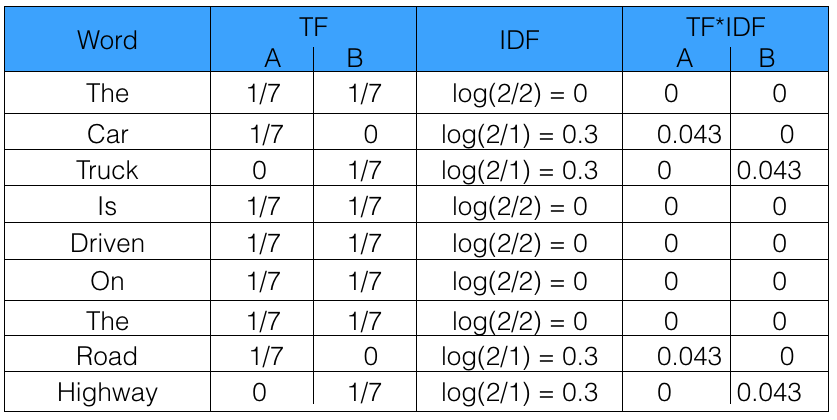

In [6]:
vectorizer = TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(newsgroups_train.data)
test_vectors = vectorizer.transform(newsgroups_test.data)

# Train Random Forest Model 
Now, let's say we want to use random forests for classification. It's usually hard to understand what random forests are doing, especially with many trees.

Let's go with 500 Trees

In [7]:
rf = RandomForestClassifier(n_estimators=500)
rf.fit(train_vectors, newsgroups_train.target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Get Performance

In [8]:
pred = rf.predict(test_vectors)
f1_score(newsgroups_test.target, pred, average='binary')

0.9198606271777003

In [9]:
accuracy_score(newsgroups_test.target, pred)

0.9037656903765691

# Get Global Feature Importances
We measure the importance of a feature by calculating the increase in the model’s prediction error after permuting the feature. A feature is “important” if shuffling its values increases the model error, because in this case the model relied on the feature for the prediction. A feature is “unimportant” if shuffling its values leaves the model error unchanged, because in this case the model ignored the feature for the prediction. The permutation feature importance measurement was introduced by Breiman (2001)34 for random forests. 

In [10]:
rounded_feature_importances = map(lambda x: round(x, 4), rf.feature_importances_)
sorted(zip(rounded_feature_importances, vectorizer.get_feature_names()), 
             reverse=True)[1:20]

[(0.021, 'Host'),
 (0.0182, 'NNTP'),
 (0.0148, 'rutgers'),
 (0.0098, 'writes'),
 (0.0093, 'Christ'),
 (0.008, 'Re'),
 (0.0076, 'athos'),
 (0.007, '1993'),
 (0.0069, 'In'),
 (0.0069, 'Christians'),
 (0.0066, 'Schneider'),
 (0.0065, 'keith'),
 (0.0061, 'Keith'),
 (0.0058, 'atheism'),
 (0.0055, 'article'),
 (0.0054, 'Nntp'),
 (0.005, 'Allan'),
 (0.0047, 'Distribution'),
 (0.0046, 'God')]

# LIME
Local interpretable model-agnostic explanations (LIME) is a paper in which the authors propose a concrete implementation of local surrogate models. Surrogate models are trained to approximate the predictions of the underlying black box model. Instead of training a global surrogate model, LIME focuses on training local surrogate models to explain individual predictions.

The idea is quite intuitive. First, forget about the training data and imagine you only have the black box model where you can input data points and get the predictions of the model. You can probe the box as often as you want. Your goal is to understand why the machine learning model made a certain prediction. LIME tests what happens to the predictions when you give variations of your data into the machine learning model. LIME generates a new dataset consisting of permuted samples and the corresponding predictions of the black box model. On this new dataset LIME then trains an interpretable model, which is weighted by the proximity of the sampled instances to the instance of interest. The interpretable model can be anything from the interpretable models chapter, for example Lasso or a decision tree. The learned model should be **a good approximation of the machine learning model predictions locally, but it does not have to be a good global approximation.** This kind of accuracy is also called local fidelity.

In [11]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(vectorizer, rf) # this goes through the vectorization > into the model

In [12]:
print(pipe.predict_proba([newsgroups_test.data[0]]))

[[0.256 0.744]]


In [13]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

In [14]:
idx = 83
exp = explainer.explain_instance(newsgroups_test.data[idx], pipe.predict_proba, num_features=6)
print('Document id: %d' % idx)
print('Probability(christian) =', pipe.predict_proba([newsgroups_test.data[idx]])[0,1])
print('True class: %s' % class_names[newsgroups_test.target[idx]])

/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


Document id: 83
Probability(christian) = 0.462
True class: atheism


In [15]:
exp.as_list()

[('Posting', -0.15101026024779066),
 ('Host', -0.1195720918700683),
 ('NNTP', -0.10520919049386217),
 ('edu', -0.040628324215573317),
 ('anyone', 0.011605575813490712),
 ('University', 0.010284393406569003)]

In [16]:
%matplotlib inline

fig = exp.as_pyplot_figure()

In [69]:
print('Original prediction:', rf.predict_proba(test_vectors[idx])[0,1])
tmp = test_vectors[idx].copy()
tmp[0,vectorizer.vocabulary_['Posting']] = 0
tmp[0,vectorizer.vocabulary_['Host']] = 0
print('Prediction removing some features:', rf.predict_proba(tmp)[0,1])
print('Difference:', rf.predict_proba(tmp)[0,1] - rf.predict_proba(test_vectors[idx])[0,1])

Original prediction: 0.452
Prediction removing some features: 0.722
Difference: 0.26999999999999996
